## Random Walk Generation

$$ \frac{S_{t+dt} - S{t}}{S_t} = {\mu}dt + {\sigma}\sqrt{dt}{\xi}_t $$

In [88]:
import numpy as np
import pandas as pd

def gbm(n_years: int=10, n_scenarios: int=1000, mu:float=0.07, sigma:float=0.15, steps_per_year: int=12, s_0: float=100.0) -> pd.DataFrame:
    """
    Evolution of a Stock Price using a Geometric Brownian Motion model
    """
    dt = 1/steps_per_year
    n_steps = int(n_years * steps_per_year)
    xi = np.random.normal(size=(n_steps + 1, n_scenarios))
    rets = mu * dt + sigma * np.sqrt(dt) * xi
    rets[0] = 0
    rets = pd.DataFrame(rets)
    # print(rets)
    prices = s_0 * (1+rets).cumprod()
    return prices

In [89]:
p = gbm(n_scenarios=3)
p.head()

,0,1,2
0,100.000000,100.000000,100.000000
1,98.810138,98.529613,100.918331
2,98.342725,103.879686,102.257261
3,92.590247,104.203774,101.792551
4,91.358611,102.689615,91.334766


<Axes: >

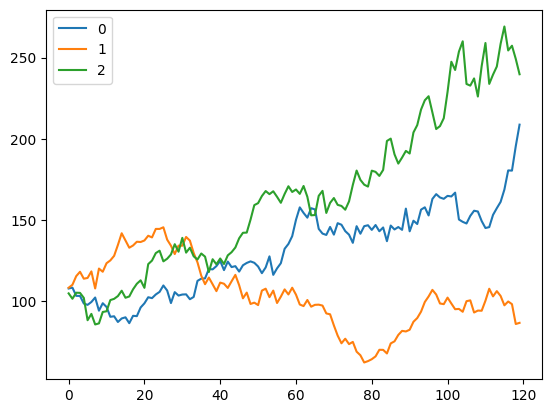

In [19]:
p.plot()

<Axes: >

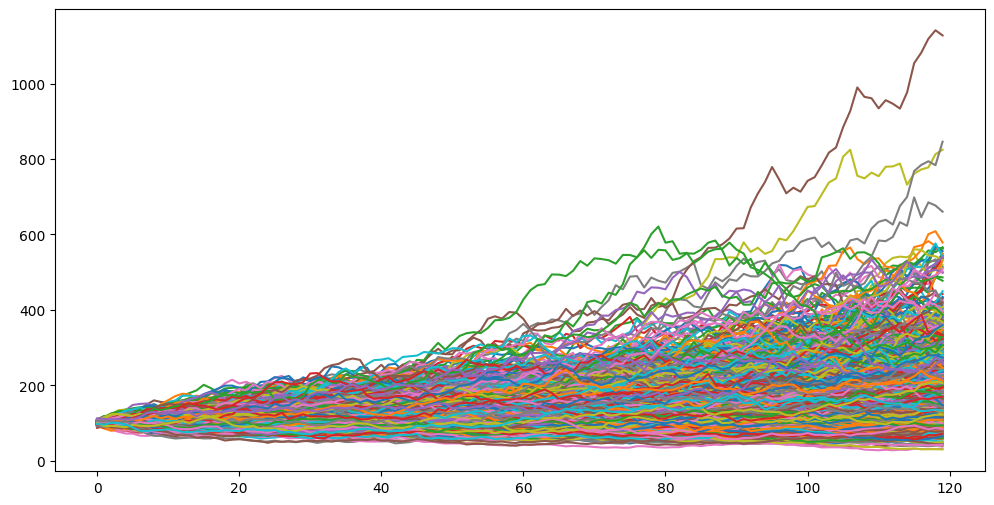

In [25]:
p = gbm(10, n_scenarios=1000)
p.plot(figsize=(12,6), legend=False)

In [91]:
import math

def gbm0(n_years: int=10, n_scenarios: int=1000, mu:float=0.07, sigma:float=0.15, steps_per_year: int=12, s_0: float=100.0) -> pd.DataFrame:
    """
    Evolution of a Stock Price using a Geometric Brownian Motion model
    """
    dt = 1/steps_per_year
    n_steps = int(n_years * steps_per_year)
    xi = np.random.normal(size=(n_steps, n_scenarios))
    rets = mu * dt + sigma * np.sqrt(dt) * xi
    rets = pd.DataFrame(rets)
    prices = s_0 * (1+rets).cumprod()
    return prices

def gbm1(n_years: int=10, n_scenarios: int=1000, mu:float=0.07, sigma:float=0.15, steps_per_year: int=12, s_0: float=100.0) -> pd.DataFrame:
    """
    Evolution of a Stock Price using a Geometric Brownian Motion model
    """
    dt = 1/steps_per_year
    n_steps = int(n_years * steps_per_year)
    rets_plus_1 = np.random.normal(loc=1+mu*dt, scale=sigma*np.sqrt(dt), size=(n_steps + 1, n_scenarios))
    rets_plus_1[0] = 1
    # rets = mu * dt + sigma * np.sqrt(dt) * xi
    prices = s_0 * pd.DataFrame(rets_plus_1).cumprod()
    return prices

gbm = gbm1

def gbm_fast(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    dt = 1.0/steps_per_year
    n_steps = int(n_years*steps_per_year)
    rng = np.random.default_rng()
    xi = rng.standard_normal((n_steps, n_scenarios))
    inc = 1.0 + mu*dt + sigma*math.sqrt(dt)*xi        # same model as yours
    prices = s_0 * np.cumprod(inc, axis=0)            # NumPy cumprod (fast)
    return pd.DataFrame(prices)

In [35]:
%timeit gbm0(5, n_scenarios=1000)

760 μs ± 4.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
%timeit gbm1(5, n_scenarios=1000)

720 μs ± 5.81 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [40]:
%timeit gbm_fast(5, n_scenarios=1000)

347 μs ± 3.04 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Using Polars

In [54]:
import polars as pl
import math

def gbm_polars(
    n_years: int = 10,
    n_scenarios: int = 1000,
    mu: float = 0.07,
    sigma: float = 0.15,
    steps_per_year: int = 12,
    s0: float = 100.0
) -> pl.DataFrame:
    dt = 1.0 / steps_per_year
    n_steps = int(n_years * steps_per_year)

    rng = np.random.default_rng()
    xi = rng.standard_normal((n_steps, n_scenarios))

    # increments: (1 + μdt + σ√dt ξ)
    inc = 1.0 + mu*dt + sigma*math.sqrt(dt)*xi

    # cumulative product along time axis
    prices = s0 * np.cumprod(inc, axis=0)

    # convert to Polars DataFrame
    return pl.DataFrame(prices, schema=[f"scenario_{i}" for i in range(n_scenarios)])

def gbm_polars_long(
    n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15,
    steps_per_year=12, s0=100.0
) -> pl.DataFrame:
    dt = 1.0 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    N = n_steps * n_scenarios

    rng = np.random.default_rng()
    xi = rng.standard_normal(N)
    step = np.tile(np.arange(n_steps, dtype=np.int32), n_scenarios)
    scen = np.repeat(np.arange(n_scenarios, dtype=np.int32), n_steps)

    df = pl.DataFrame({"scenario": scen, "step": step, "xi": xi})

    sqdt = math.sqrt(dt)
    drift = mu * dt
    vol   = sigma * sqdt

    out = (
        df.with_columns(
            (1.0 + drift + vol * pl.col("xi")).alias("inc")
        )
        .with_columns(
            (
                (pl.col("inc").log().cum_sum().over("scenario").exp() * s0)
                .alias("price")
            )
        )
        .select("scenario", "step", "price")
    )

    return out

In [42]:
df = gbm_polars(n_years=5, n_scenarios=3)
print(df.head())

shape: (5, 3)
┌────────────┬────────────┬────────────┐
│ scenario_0 ┆ scenario_1 ┆ scenario_2 │
│ ---        ┆ ---        ┆ ---        │
│ f64        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╡
│ 106.730763 ┆ 97.313568  ┆ 101.940946 │
│ 108.701722 ┆ 102.129732 ┆ 101.182824 │
│ 100.99471  ┆ 100.066387 ┆ 95.135924  │
│ 103.635157 ┆ 97.146311  ┆ 97.893921  │
│ 103.884696 ┆ 96.543693  ┆ 101.026221 │
└────────────┴────────────┴────────────┘


In [44]:
%timeit gbm_polars(5, n_scenarios=1000)

1.85 ms ± 15.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [55]:
df = gbm_polars_long(n_years=5, n_scenarios=3)
print(df.head())

shape: (5, 3)
┌──────────┬──────┬────────────┐
│ scenario ┆ step ┆ price      │
│ ---      ┆ ---  ┆ ---        │
│ i32      ┆ i32  ┆ f64        │
╞══════════╪══════╪════════════╡
│ 0        ┆ 0    ┆ 100.648639 │
│ 0        ┆ 1    ┆ 99.851518  │
│ 0        ┆ 2    ┆ 105.826391 │
│ 0        ┆ 3    ┆ 109.070645 │
│ 0        ┆ 4    ┆ 106.714598 │
└──────────┴──────┴────────────┘


In [56]:
%timeit gbm_polars_long(5, n_scenarios=1000)

1.25 ms ± 2.29 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [81]:
# allow RNG reuse to avoid re-initialization cost in tight loops
_rng = np.random.default_rng()

def gbm_fast2(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15,
              steps_per_year=12, s0=100.0, rng=_rng, dtype=np.float32) -> pd.DataFrame:
    dt   = 1.0 / steps_per_year
    n    = int(n_years * steps_per_year)
    sqdt = math.sqrt(dt)

    # generate shocks directly in target dtype
    xi   = rng.standard_normal((n+1, n_scenarios)).astype(dtype)

    # convert constants to dtype explicitly
    drift = np.array(1 + mu*dt, dtype=dtype)
    vol   = np.array(sigma*sqdt, dtype=dtype)

    inc  = drift + vol * xi
    inc[0] = 1
    prices = s0 * np.cumprod(inc, axis=0, dtype=dtype)

    return pd.DataFrame(prices)

In [82]:
df = gbm_fast2(n_years=5, n_scenarios=3)
print(df.head())

            0           1           2
0  100.000000  100.000000  100.000000
1   97.590614   98.246323  107.770584
2   99.052635  101.422974  103.193413
3   94.768463  100.172470  108.647118
4   85.549095   94.576241  111.980888


In [83]:
%timeit gbm_fast2(5, n_scenarios=1000)

338 μs ± 5.67 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<Axes: >

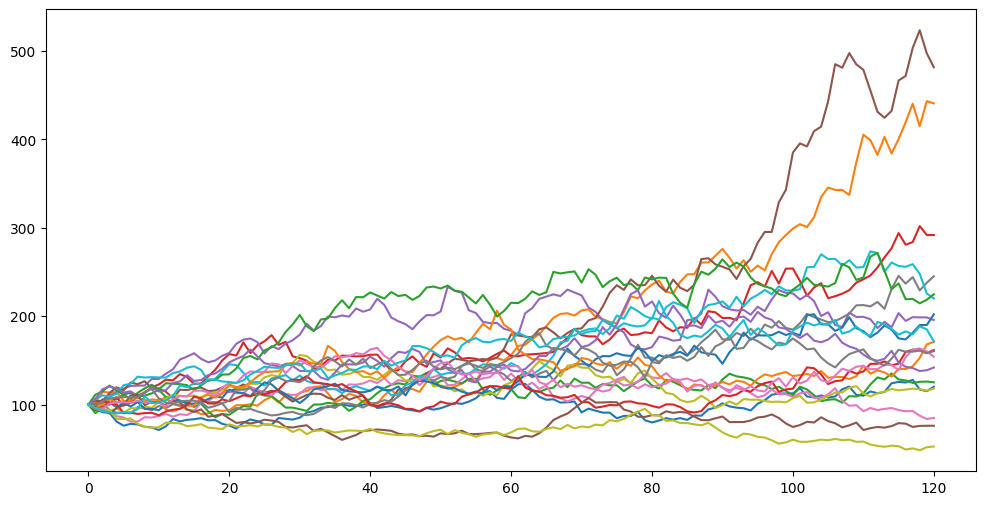

In [92]:
gbm(10, n_scenarios=20).plot(legend=False, figsize=(12,6))